In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
%load_ext autoreload
%autoreload 2

from core import *
from torch_backend import *
import  torch.nn.functional  as F

In [3]:
def mse(inp, target):
    return F.mse_loss(inp, target)

### Network definitions

In [4]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), [rel_path('in')]),
        'concat': (Concat(), [rel_path('avgpool')]),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'classifier': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, stride=1, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.AvgPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.AvgPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.CrossEntropyLoss(reduce=False), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Download and preprocess data

In [5]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))

train_set = list(zip(transpose(dataset['train']['data'][:1024]), dataset['train']['labels']))
test_set = list(zip(transpose(dataset['test']['data'][:4096]), dataset['test']['labels']))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.6 seconds
Preprocessing test data
Finished in 0.11 seconds


### Training loop

In [6]:
def train(model, lr_schedule, optimizer, train_set, test_set, batch_size, num_workers=0):
    train_batches = Batches(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    optimizer.opt_params['lr'] = lambda step: lr_schedule(step/len(train_batches))/batch_size
    table, timer = TableLogger(), Timer()
    for epoch in range(lr_schedule.knots[-1]):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True) 
        summary = union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, epoch_stats)
        table.append(summary)
    return summary

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

In [7]:
device = 'cuda'
train_subset = 4096
test_subset = 4096

In [8]:
#y_train = np.eye(10, dtype="float32")[dataset['train']['labels']][:train_subset]
#y_test = np.eye(10, dtype="float32")[dataset['test']['labels']][:test_subset]
y_train = dataset['train']['labels'][:train_subset]
y_test = dataset['test']['labels'][:test_subset]

X_train = transpose(dataset['train']['data'][:train_subset])
X_test = transpose(dataset['test']['data'][:test_subset])

Finished in 1.4e+02 seconds
{'prep': {'conv': Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace)}, 'layer1': {'conv': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPool2d(kernel_size=2, stride=2, padding=0)}, 'layer2': {'conv': Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPool2d(kernel_size=2, stride=2, padding=0)}, 'layer3': {'conv': Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPool2

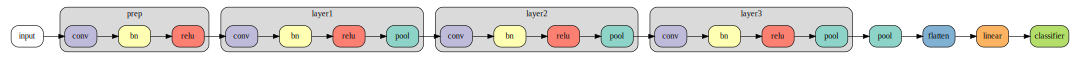

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       1.5619       2.2690       0.1792       0.1682       2.2664       0.1904       1.7300
           2       0.0667       0.4877       2.0915       0.2510       0.1696       2.0819       0.2805       2.3874
           3       0.1000       0.4870       1.9091       0.3086       0.1686       1.9724       0.2725       3.0430
           4       0.1333       0.4869       1.7481       0.3464       0.1685       2.0159       0.2644       3.6984
           5       0.1667       0.4880       1.6297       0.3918       0.1691       1.8080       0.3230       4.3555
           6       0.2000       0.4886       1.5730       0.4146       0.1695       3.9578       0.1914       5.0136
           7       0.2333       0.4875       1.4865       0.4539       0.1689       5.1433       0.1226       5.6700
           8       0.2667       0.4876       1.4368       0.4800

In [ ]:
train_set = list(zip(X_train, y_train))
test_set = list(zip(X_test, y_test))

#train_set = list(zip(transpose(dataset['train']['data'][:4096]), dataset['train']['labels']))
#test_set = list(zip(transpose(dataset['test']['data'][:4096]), dataset['test']['labels']))

print(f'Finished in {t():.2} seconds')
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 256
c = 128
n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
print(n)
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [])

summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

In [112]:
train_set_x

In [ ]:
print(summary)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 